In [1]:
import mdtraj as md
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA

In [3]:
def plot_potential_energy(md_platform, state_file_list, plot_type, window):
    energy_arrays = []
    labels = []
    for i, state_file in enumerate(state_file_list):
        if md_platform == 'openmm':
            df = pd.read_csv(state_file)
        elif md_platform == 'gromacs':
            csv_file = os.path.splitext(state_file)[0] + '.csv'
            with open(state_file, 'r') as fin, open(csv_file, 'w') as fout:
                for line in fin:
                    if not (line.startswith('@') or line.startswith('#')):
                        fout.write(','.join(line.split()) + '\n')
            #df = pd.read_csv(csv_file, header=None) #ignore the first row as initial state
            df = pd.read_csv(csv_file)
            df.columns = ['time', 'Potential Energy (kJ/mole)']
        energy = df['Potential Energy (kJ/mole)'].to_numpy()
        n_windows = len(energy) // window
        avg_energy = np.array([energy[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        energy_arrays.append(avg_energy)
        labels.append(f'replicate {i+1}')
        if plot_type == 'line':
            plt.plot(avg_frames, avg_energy, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('Potential Energy (kJ/mole)')
            plt.title(f'Potential Energy Over Time (Window = {window} frames)')
            plt.ylim(np.mean(energy) - 5*np.std(energy), np.mean(energy) + 5*np.std(energy))
        elif plot_type == 'hist':
            sns.kdeplot(avg_energy, label=labels[-1])
            plt.xlabel('Potential Energy (kJ/mole)')
            plt.title('Potential Energy Distribution')
            plt.xlim(np.mean(energy) - 5*np.std(energy), np.mean(energy) + 5*np.std(energy))
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    #return energy_arrays

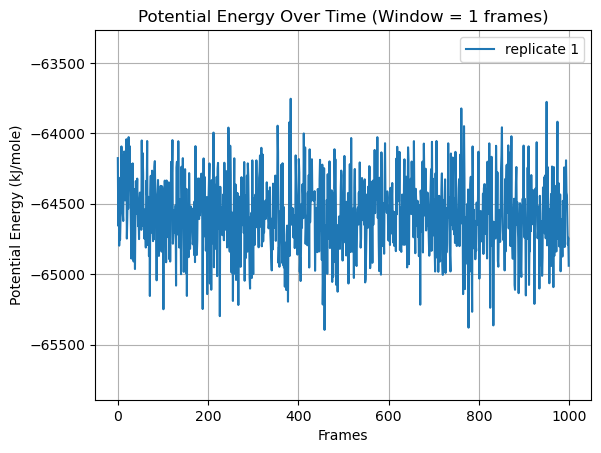

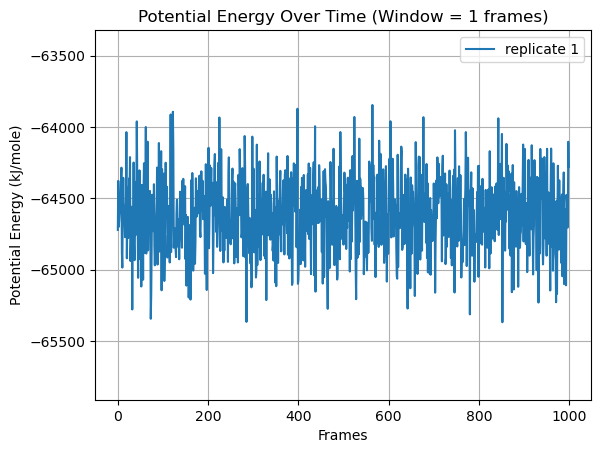

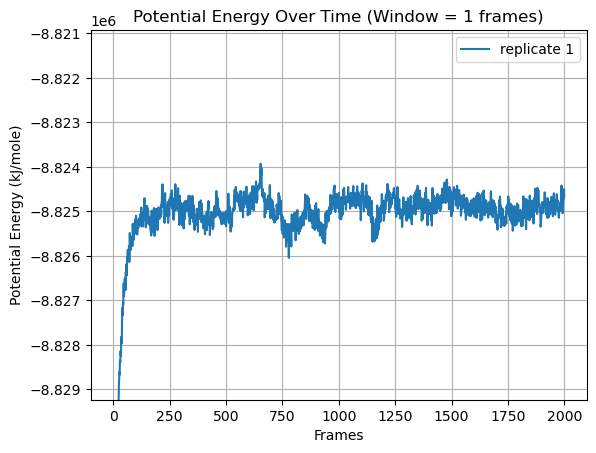

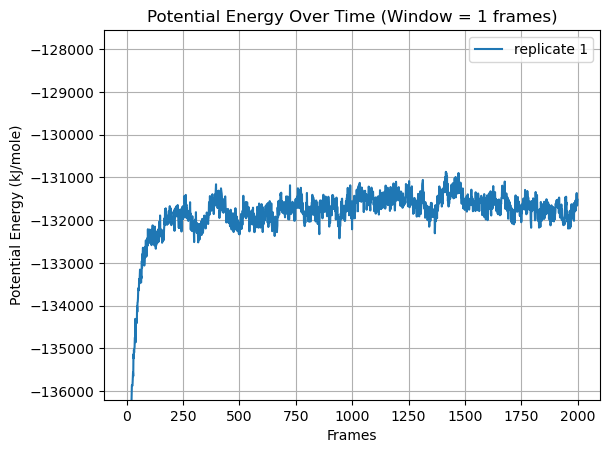

In [4]:
plot_potential_energy('openmm', ['classic/classic_gaff/energy_data.csv'], 'line', 1)
plot_potential_energy('openmm', ['classic/classic_sage/energy_data.csv'], 'line', 1)
plot_potential_energy('openmm', ['classic/classic_ANI2x/data.csv'], 'line', 1)
plot_potential_energy('openmm', ['classic/classic_MACEsmall/data.csv'], 'line', 1)

In [15]:
def plot_rmsd_fluctuations_multiple(traj_files, top_file, plot_type, window, saved_file_paths):
    rmsd_arrays = []
    labels = []
    for i, traj_file in enumerate(traj_files):
        traj = md.load(traj_file, top=top_file)
        try:
            traj.image_molecules(inplace=True)
        except:
            pass
        frames = np.arange(0, traj.n_frames)
        ligand_atoms = traj.topology.select('resname UNK')
        traj.superpose(traj, frame=0, atom_indices=ligand_atoms)
        traj.save(saved_file_paths[i])
        result = traj.xyz[:, ligand_atoms, :] - traj.xyz[0, ligand_atoms, :]
        ligand_rmsd = np.sqrt((result ** 2).sum(axis=-1).mean(axis=-1))
        n_windows = len(ligand_rmsd) // window
        avg_rmsd = np.array([ligand_rmsd[i*window:(i+1)*window].mean() for i in range(n_windows)])
        avg_frames = np.arange(n_windows) * window
        rmsd_arrays.append(avg_rmsd)
        labels.append(f'replicate {i+1}')
        if plot_type == 'line':
            plt.plot(avg_frames, avg_rmsd, label=labels[-1])
            plt.xlabel('Frames')
            plt.ylabel('RMSD (nm)')
            plt.title(f'Ligand RMSD under Protein Alignment')
        elif plot_type == 'hist':
            sns.kdeplot(avg_rmsd, label=labels[-1])
            plt.xlabel('RMSD (nm)')
            plt.title('Ligand RMSD Distribution under Protein Alignment')
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close()
    return traj

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


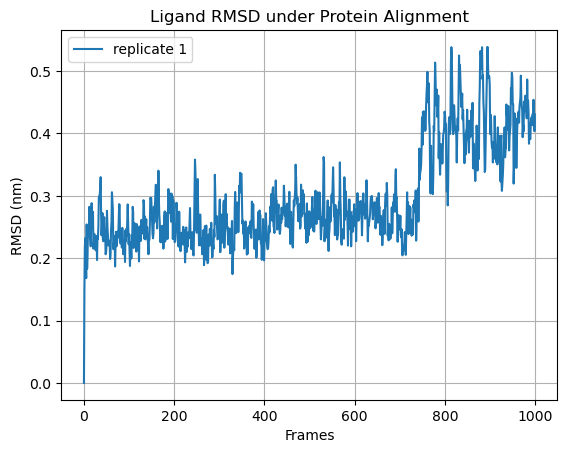

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


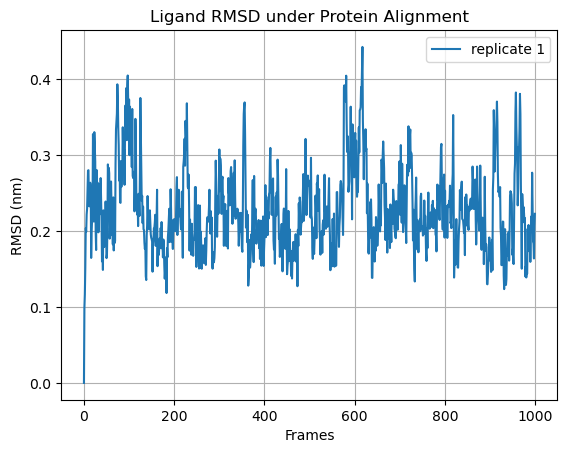

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


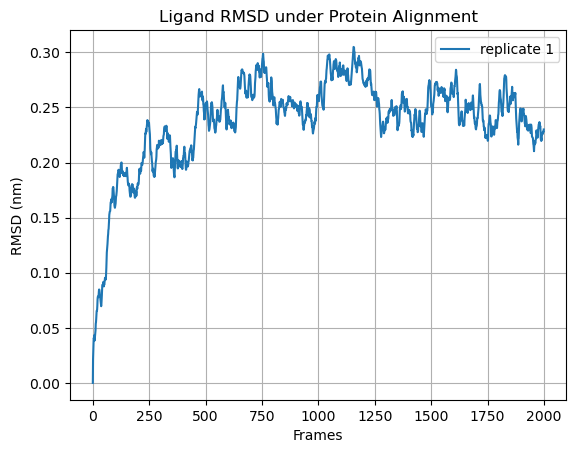

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


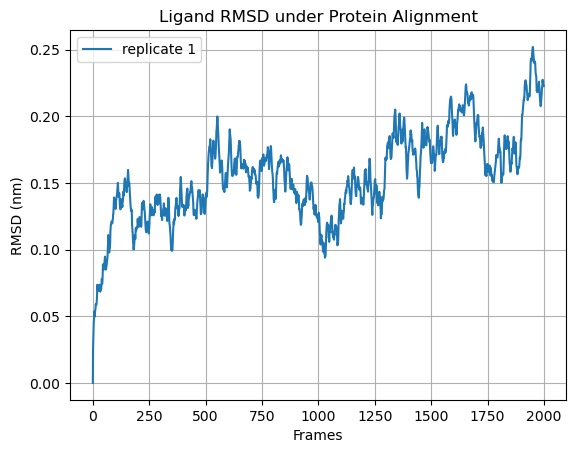

In [16]:
trj_gaff = plot_rmsd_fluctuations_multiple(['classic/classic_gaff/trajectory.dcd'], 'classic/classic_gaff/gaff_ligand_in_solvent.pdb', 'line', 1, ['classic/classic_gaff/processed.xtc'])
trj_sage = plot_rmsd_fluctuations_multiple(['classic/classic_sage/trajectory.dcd'], 'classic/classic_sage/ligand_in_solvent.pdb', 'line', 1, ['classic/classic_sage/processed.xtc'])
trj_ani  = plot_rmsd_fluctuations_multiple(['classic/classic_ANI2x/test_ani_mixed.dcd'], 'classic/classic_ANI2x/gaff_ligand_in_solvent.pdb', 'line', 1, ['classic/classic_ANI2x/processed.xtc'])
trj_mace = plot_rmsd_fluctuations_multiple(['classic/classic_MACEsmall/test_mace_mixed.dcd'], 'classic/classic_MACEsmall/gaff_ligand_in_solvent.pdb', 'line', 1, ['classic/classic_MACEsmall/processed.xtc'])

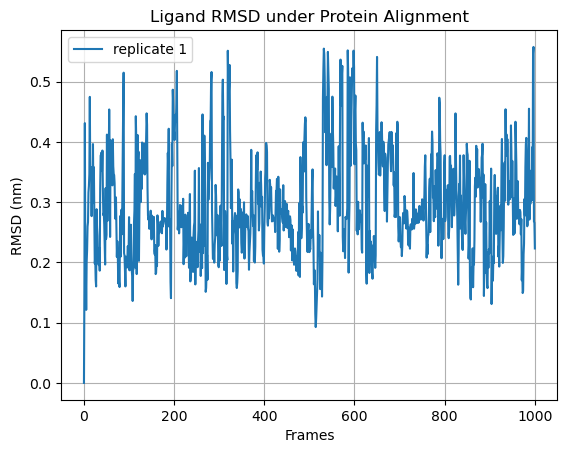

In [17]:
trj_sage_remd = plot_rmsd_fluctuations_multiple(['REMD/REMD_2/replicate_0/md_pbc_fit.xtc'], 'REMD/REMD_2/ligand_in_solvent.pdb', 'line', 1, ['REMD/REMD_2/0_processed.xtc'])

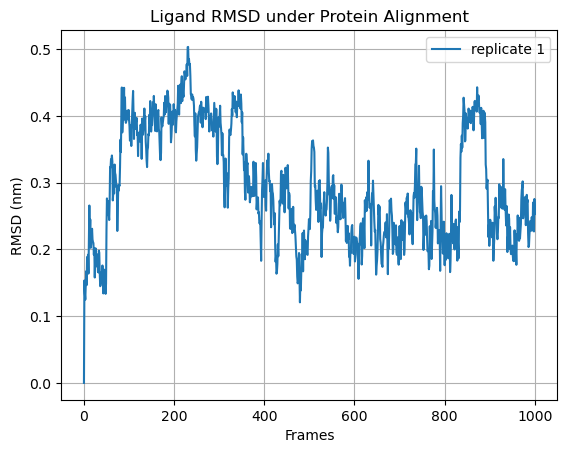

In [18]:
trj_sage_rest = plot_rmsd_fluctuations_multiple(['REST/REST_4/replica_0_ligand_samples.pdb'], 'REST/ligand.pdb', 'line', 1, ['REST/REST_4/0_processed.xtc'])

In [19]:
def plot_dihedral_angles(traj_cont, atom_indices):
    dihedral_angles = md.compute_dihedrals(traj_cont, [atom_indices])
    dihedral_angles_deg = np.degrees(dihedral_angles[:, 0])
    plt.figure(figsize=(8, 6))
    sns.kdeplot(dihedral_angles_deg)
    plt.xlabel('Dihedral Angle (degrees)')
    plt.ylabel('Density')
    plt.title('Dihedral Angle Distribution')
    plt.xlim(-180, 180)
    plt.grid(True)
    plt.show()
    plt.close()
    return np.mean(dihedral_angles_deg)

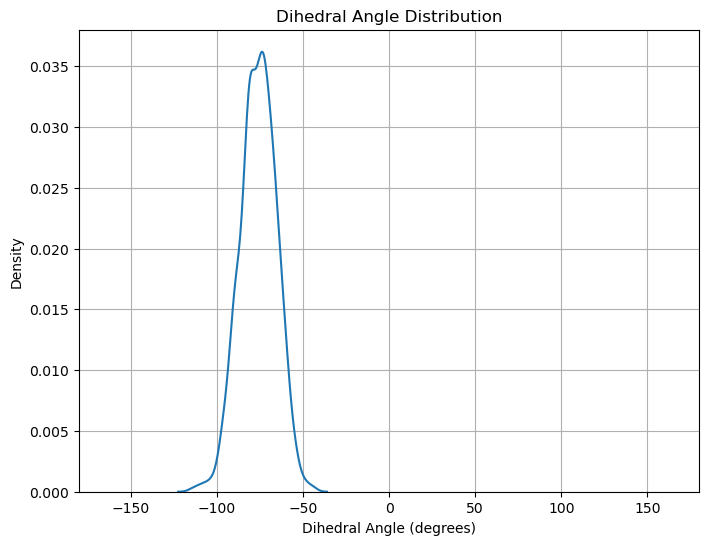

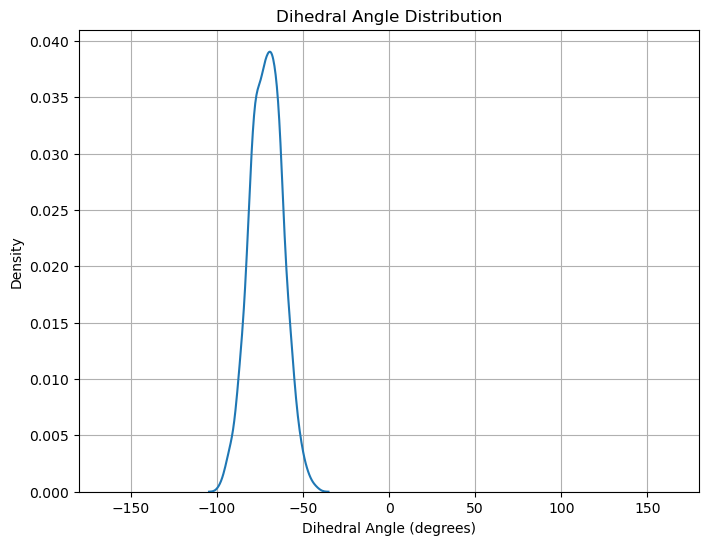

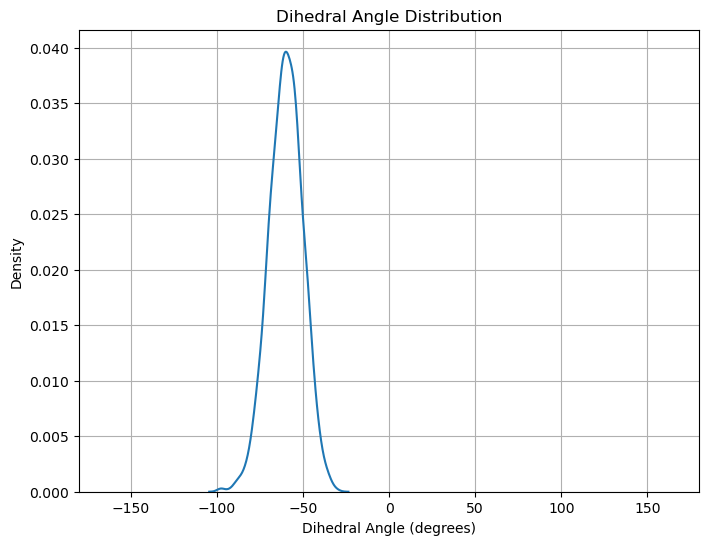

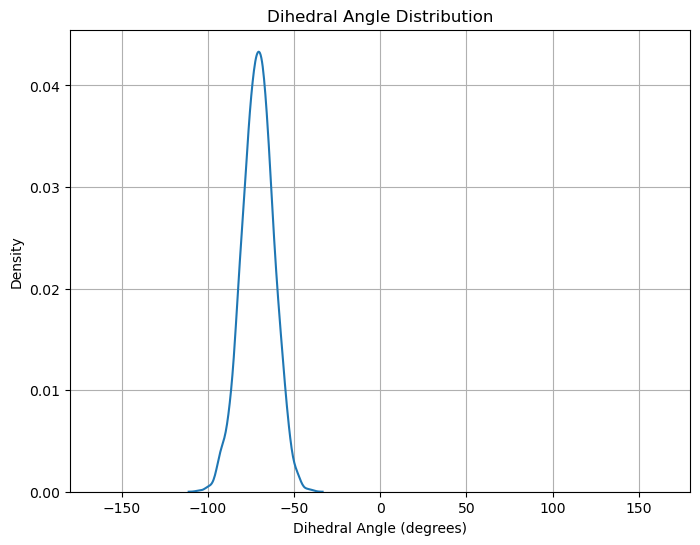

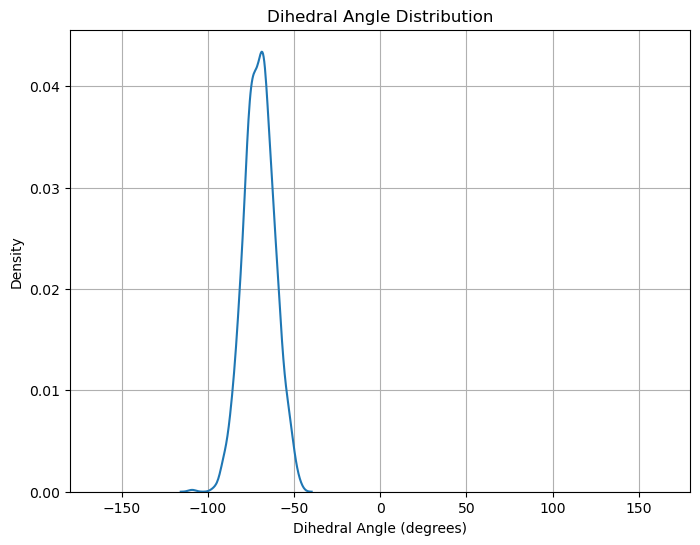

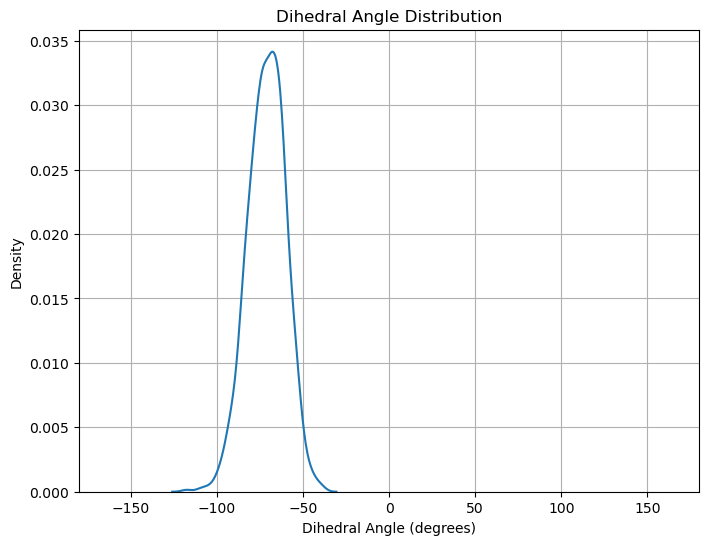

-71.1761

In [20]:
plot_dihedral_angles(trj_gaff, [11, 10, 9, 4])
plot_dihedral_angles(trj_sage, [11, 10, 9, 4])
plot_dihedral_angles(trj_ani, [11, 10, 9, 4])
plot_dihedral_angles(trj_mace, [11, 10, 9, 4])
plot_dihedral_angles(trj_sage_remd, [11, 10, 9, 4])
plot_dihedral_angles(trj_sage_rest, [11, 10, 9, 4])

In [21]:
def plot_distance(traj_cont, atom_indices):
    atom_pairs = np.array([atom_indices])
    distances = md.compute_distances(traj_cont, atom_pairs)
    distance = distances[:, 0]
    plt.figure(figsize=(8, 6))
    sns.kdeplot(distance)
    plt.xlabel('Distance (nm)')
    plt.ylabel('Density')
    plt.title('Distance Distribution')
    plt.xlim(0.3, 0.4)
    plt.grid(True)
    plt.show()
    plt.close()
    return np.mean(distance)

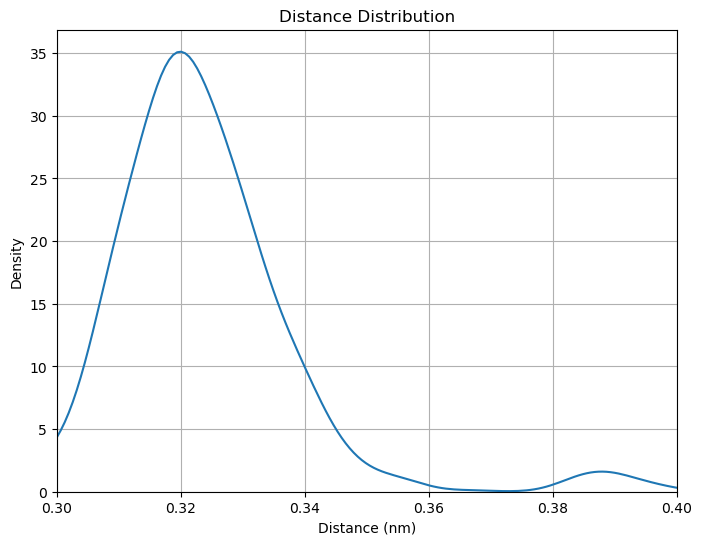

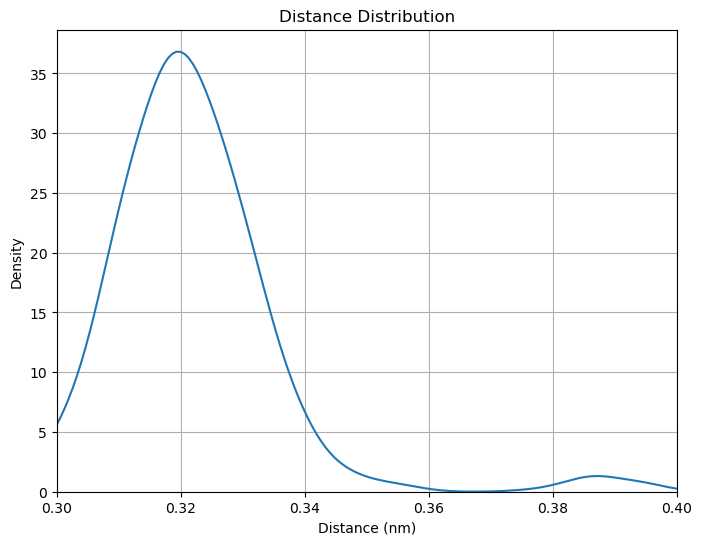

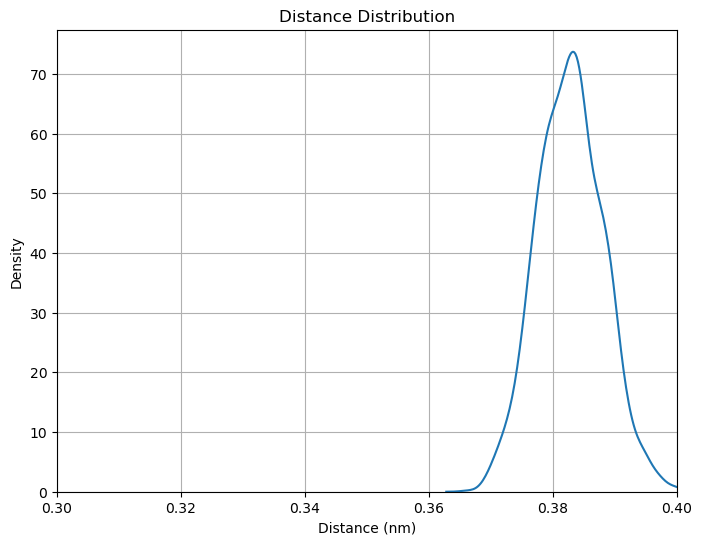

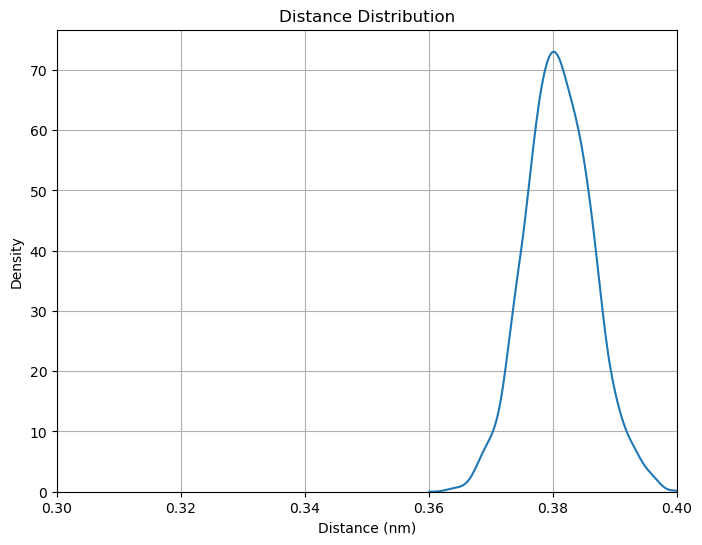

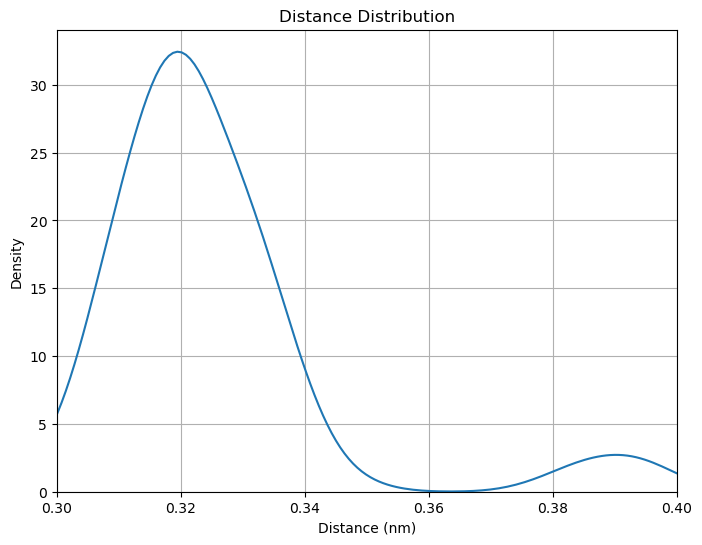

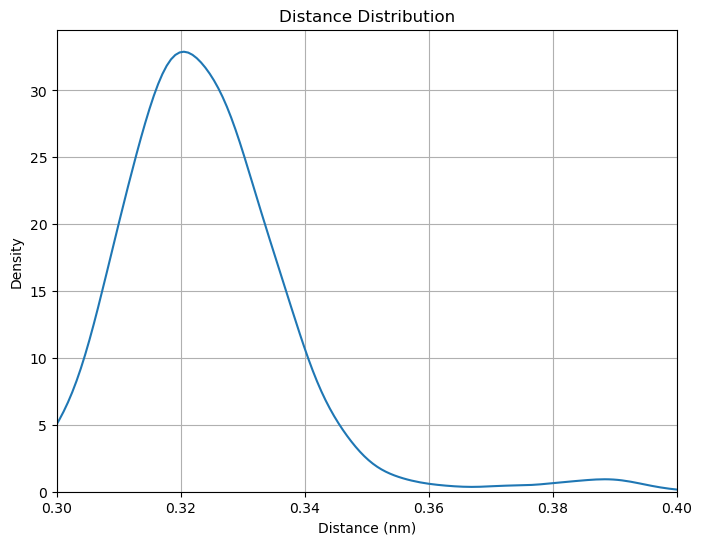

0.32365546

In [22]:
plot_distance(trj_gaff, [55, 58])
plot_distance(trj_sage, [55, 58])
plot_distance(trj_ani, [55, 58])
plot_distance(trj_mace, [55, 58])
plot_distance(trj_sage_remd, [55, 58])
plot_distance(trj_sage_rest, [55, 58])

In [24]:
def plot_ligand_pca(traj_files, top_file, slice_step=1):
        traj_cont = md.load(traj_files[0], top=top_file)[::slice_step]
        for i, traj_file in enumerate(traj_files[1:]):
                traj = md.load(traj_file, top=top_file)[::slice_step]
                traj_cont = md.join([traj_cont, traj])
        try:    
                traj_cont.image_molecules(inplace=True)
        except:
                pass
        ligand_atoms = traj_cont.topology.select('resname UNK')
        traj_cont.superpose(traj_cont, frame=0, atom_indices=ligand_atoms)
        ligand_xyz = traj_cont.xyz[:, ligand_atoms, :]
        ligand_xyz_flat = ligand_xyz.reshape(traj_cont.n_frames, len(ligand_atoms) * 3)
        pca1 = PCA(n_components=2)
        reduced_cartesian = pca1.fit_transform(ligand_xyz_flat)
        plt.figure(figsize=(8, 6))
        kde = sns.kdeplot(
                x=reduced_cartesian[:, 0],
                y=reduced_cartesian[:, 1],
                fill=True,
                cmap="viridis",
                thresh=0,
                levels=100
        )
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('KDE of Ligand PCA Coordinates')
        mappable = kde.collections[0]
        plt.colorbar(mappable, label='Density')
        plt.show()
        plt.close()
        return traj_cont

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


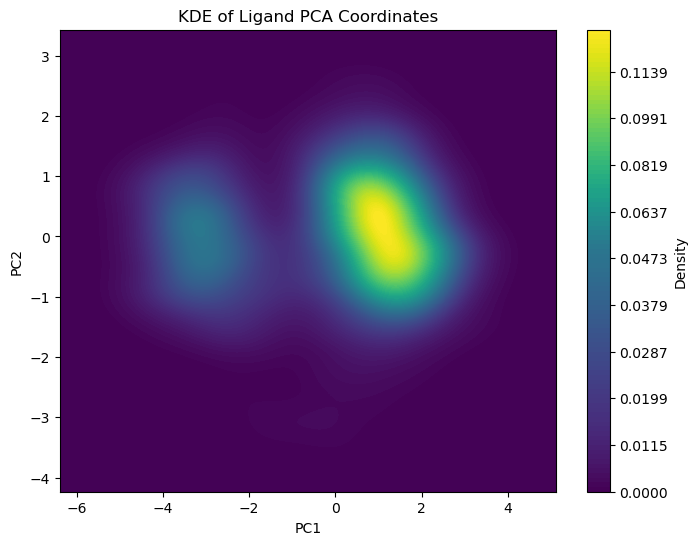

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


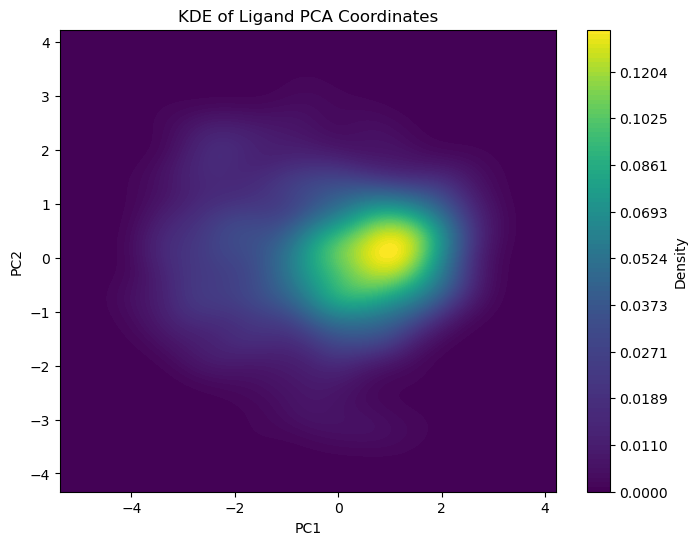

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


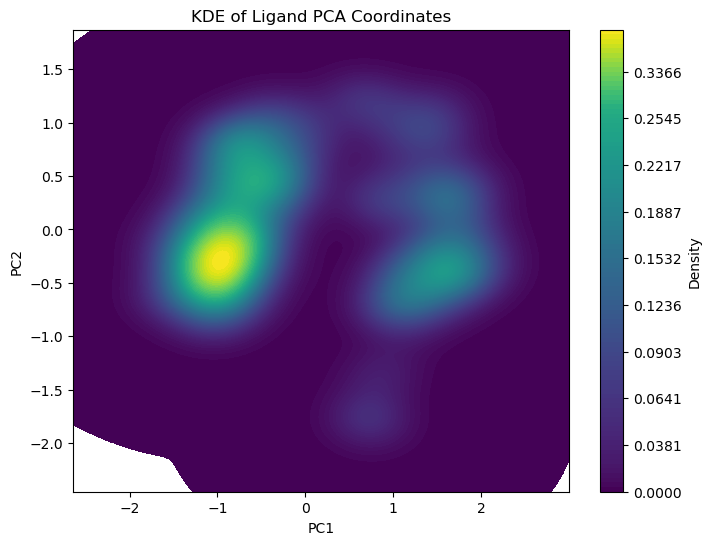

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


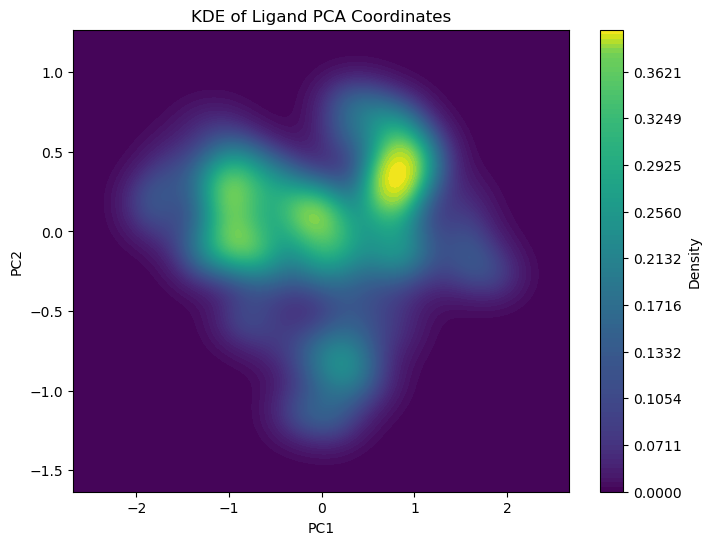

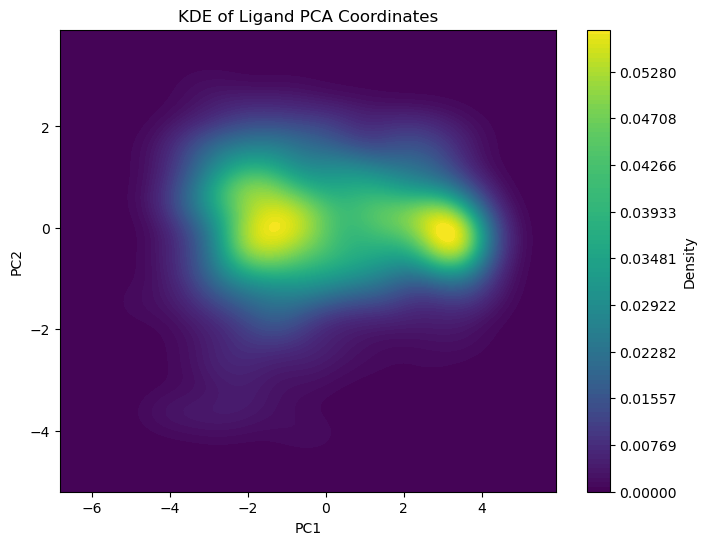

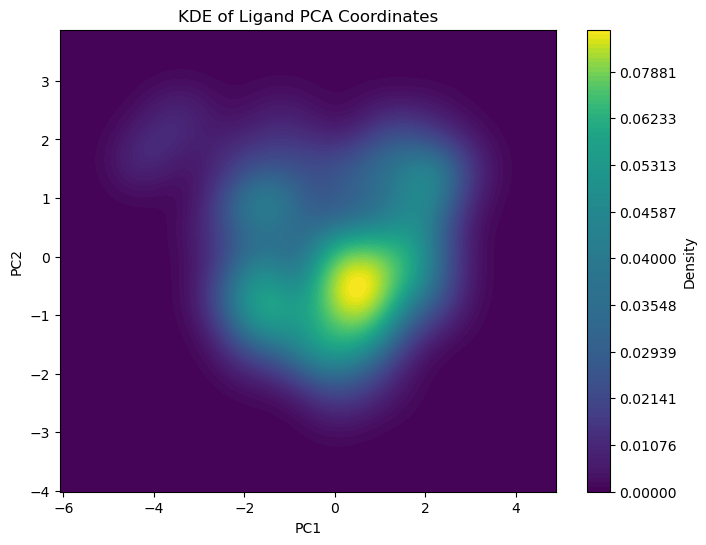

<mdtraj.Trajectory with 501 frames, 151 atoms, 1 residues, without unitcells at 0x7593afcf9950>

In [28]:
plot_ligand_pca(['classic/classic_gaff/trajectory.dcd'], 'classic/classic_gaff/gaff_ligand_in_solvent.pdb')
plot_ligand_pca(['classic/classic_sage/trajectory.dcd'], 'classic/classic_sage/ligand_in_solvent.pdb')
plot_ligand_pca(['classic/classic_ANI2x/test_ani_mixed.dcd'], 'classic/classic_ANI2x/gaff_ligand_in_solvent.pdb')
plot_ligand_pca(['classic/classic_MACEsmall/test_mace_mixed.dcd'], 'classic/classic_MACEsmall/gaff_ligand_in_solvent.pdb')
plot_ligand_pca(['REMD/REMD_2/0_sorted_md_pbc.xtc'], 'REMD/ligand_in_solvent.pdb')
plot_ligand_pca(['REST/REST_2/replica_0_ligand_samples.pdb'], 'REST/ligand.pdb')

In [30]:
import os
import json
import pandas as pd
def extract_and_split_data(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
                all_data.append({'filename': filename, 'energy': data["total energy"], 'HOMO_LUMO_gap': data["HOMO-LUMO gap / eV"]})
                df = pd.DataFrame(all_data)
    return df

df = extract_and_split_data('XTB_opt')
df
 

,filename,energy,HOMO_LUMO_gap
0,ANI2x_0001_opt.json,-221.318412,2.520763
1,ANI2x_0002_opt.json,-221.318331,2.539099
2,ANI2x_0003_opt.json,-221.319437,2.525212
3,ANI2x_0004_opt.json,-221.318942,2.535930
4,ANI2x_0005_opt.json,-221.319178,2.525628
...,...,...,...
11001,SAGE_0996_opt.json,-221.321926,2.631728
11002,SAGE_0997_opt.json,-221.325065,2.679623
11003,SAGE_0998_opt.json,-221.323575,2.700723
11004,SAGE_0999_opt.json,-221.323211,2.514509


In [31]:
df['method'] = df['filename'].apply(lambda x: x.split('_')[0])
df

,filename,energy,HOMO_LUMO_gap,method
0,ANI2x_0001_opt.json,-221.318412,2.520763,ANI2x
1,ANI2x_0002_opt.json,-221.318331,2.539099,ANI2x
2,ANI2x_0003_opt.json,-221.319437,2.525212,ANI2x
3,ANI2x_0004_opt.json,-221.318942,2.535930,ANI2x
4,ANI2x_0005_opt.json,-221.319178,2.525628,ANI2x
...,...,...,...,...
11001,SAGE_0996_opt.json,-221.321926,2.631728,SAGE
11002,SAGE_0997_opt.json,-221.325065,2.679623,SAGE
11003,SAGE_0998_opt.json,-221.323575,2.700723,SAGE
11004,SAGE_0999_opt.json,-221.323211,2.514509,SAGE


In [32]:
df_final = df[df['method'].isin(['GAFF', 'SAGE', 'ANI2x', 'MACEsmall', 'REMD', 'REST600d'])]
df_final

,filename,energy,HOMO_LUMO_gap,method
0,ANI2x_0001_opt.json,-221.318412,2.520763,ANI2x
1,ANI2x_0002_opt.json,-221.318331,2.539099,ANI2x
2,ANI2x_0003_opt.json,-221.319437,2.525212,ANI2x
3,ANI2x_0004_opt.json,-221.318942,2.535930,ANI2x
4,ANI2x_0005_opt.json,-221.319178,2.525628,ANI2x
...,...,...,...,...
11001,SAGE_0996_opt.json,-221.321926,2.631728,SAGE
11002,SAGE_0997_opt.json,-221.325065,2.679623,SAGE
11003,SAGE_0998_opt.json,-221.323575,2.700723,SAGE
11004,SAGE_0999_opt.json,-221.323211,2.514509,SAGE


In [33]:
df_final['method'] = df_final['method'].apply(lambda x: 'SAGE (REMD500)' if x == 'REMD' else x)
df_final['method'] = df_final['method'].apply(lambda x: 'SAGE (REST600)' if x == 'REST600d' else x)
df_final

/tmp/ipykernel_9709/1206987185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['method'] = df_final['method'].apply(lambda x: 'SAGE (REMD500)' if x == 'REMD' else x)
/tmp/ipykernel_9709/1206987185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['method'] = df_final['method'].apply(lambda x: 'SAGE (REST600)' if x == 'REST600d' else x)


,filename,energy,HOMO_LUMO_gap,method
0,ANI2x_0001_opt.json,-221.318412,2.520763,ANI2x
1,ANI2x_0002_opt.json,-221.318331,2.539099,ANI2x
2,ANI2x_0003_opt.json,-221.319437,2.525212,ANI2x
3,ANI2x_0004_opt.json,-221.318942,2.535930,ANI2x
4,ANI2x_0005_opt.json,-221.319178,2.525628,ANI2x
...,...,...,...,...
11001,SAGE_0996_opt.json,-221.321926,2.631728,SAGE
11002,SAGE_0997_opt.json,-221.325065,2.679623,SAGE
11003,SAGE_0998_opt.json,-221.323575,2.700723,SAGE
11004,SAGE_0999_opt.json,-221.323211,2.514509,SAGE


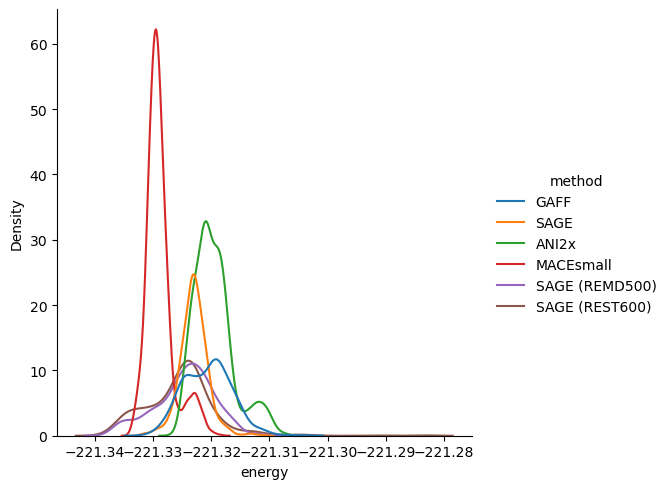

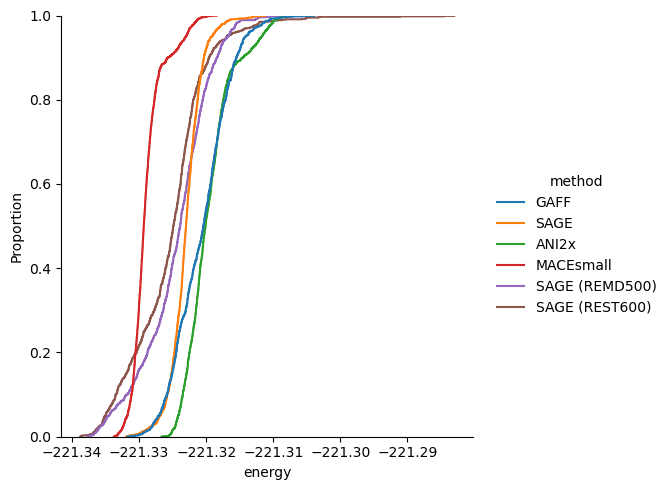

In [34]:
import seaborn as sns
from matplotlib import pyplot as plt
hue_order = ['GAFF', 'SAGE', 'ANI2x', 'MACEsmall', 'SAGE (REMD500)', 'SAGE (REST600)']
sns.displot(data=df_final, x='energy', kind='kde', hue='method', hue_order=hue_order)
sns.displot(data=df_final, x='energy', kind='ecdf', hue='method', hue_order=hue_order)